<a href="https://colab.research.google.com/github/Brian-ovita/Brian-ovita/blob/main/TextClassificationWineDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

Load the dataset

In [4]:
df = pd.read_csv("wine-reviews.csv", usecols = ['description','points','variety','winery'])
df.head()

,description,points,variety,winery
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,Nicosia
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,Quinta dos Avidagos
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,Rainstorm
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,St. Julian
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,Sweet Cheeks


In [6]:
df = df.dropna(subset=['description','points'])

In [7]:
##Create a binary label for the points column
df["label"] = (df.points >= 90).astype(int)

## Columns to be used
df = df[['description','label']]

In [8]:
## slitting the data
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [9]:
## check the lengths of train, val, test
len(train), len(val), len(test)

(103976, 12997, 12998)

In [10]:
## from tensorflow 
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [12]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [13]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.06818344, -0.06905691,  0.23413883, ..., -0.2105626 ,
        -0.1324701 , -0.0306711 ],
       [ 0.36885288, -0.1992728 ,  0.07355382, ...,  0.06638262,
         0.08346444, -0.2631661 ],
       [ 0.25451595,  0.0127784 ,  0.05763447, ..., -0.00998893,
         0.06085879,  0.15931268],
       ...,
       [ 0.32685202, -0.11282697,  0.38881776, ..., -0.25733894,
        -0.22185624, -0.13755569],
       [ 0.23629107, -0.15186687, -0.07652458, ..., -0.10531668,
        -0.21770394, -0.05982653],
       [ 0.39907205, -0.17501868,  0.15102386, ..., -0.14321887,
        -0.05058718,  0.21449476]], dtype=float32)>

In [14]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=['accuracy'])

In [16]:
model.evaluate(train_data)

102/102 [==============================] - 3s 10ms/step - loss: 0.1811 - accuracy: 0.4274


[0.18108627200126648, 0.4274255633354187]

In [17]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 9ms/step - loss: 0.1815 - accuracy: 0.4238


[0.18151505291461945, 0.4237900972366333]

In [18]:
history = model.fit(train_data, epochs=5, validation_data= valid_data)

Epoch 1/5
102/102 [==============================] - 54s 513ms/step - loss: 0.1586 - accuracy: 0.6352 - val_loss: 0.1269 - val_accuracy: 0.7766
Epoch 2/5
102/102 [==============================] - 54s 532ms/step - loss: 0.1227 - accuracy: 0.7729 - val_loss: 0.1038 - val_accuracy: 0.8187
Epoch 3/5
102/102 [==============================] - 56s 551ms/step - loss: 0.1064 - accuracy: 0.8132 - val_loss: 0.0988 - val_accuracy: 0.8233
Epoch 4/5
102/102 [==============================] - 54s 525ms/step - loss: 0.0973 - accuracy: 0.8340 - val_loss: 0.0953 - val_accuracy: 0.8308
Epoch 5/5
102/102 [==============================] - 54s 525ms/step - loss: 0.0901 - accuracy: 0.8501 - val_loss: 0.0943 - val_accuracy: 0.8333


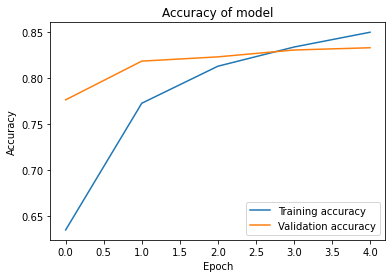

In [19]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

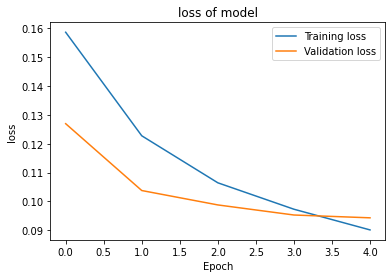

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss of model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
model.evaluate(test_data)

13/13 [==============================] - 2s 114ms/step - loss: 0.0979 - accuracy: 0.8281


[0.09787427634000778, 0.8280504941940308]